In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D

import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table, join

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-04-04_figures'
save = False

In [239]:
quants = {}

In [240]:
fn_quants = '../data/quantities_comparison.txt'
save = True

Names

In [6]:
name_gpurer = "\emph{{Gaia}} DR3 Quasars 'Purer' Sample"
abbrv_gpurer = "\emph{{Gaia}} DR3 'Purer'"

name_sqall = "SDSS DR16Q Quasars"
abbrv_sqall = "SDSS DR16Q Quasars"

Plotting variables

In [7]:
cmap_map = 'plasma'

Functions

In [8]:
def get_map(ras, decs):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

In [9]:
# via eqn 2, https://www.aanda.org/articles/aa/full_html/2015/02/aa23280-13/aa23280-13.html
def r_sdss_to_G_gaia(r):
    return 0.97 * r + 0.39

Map settings

In [10]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [11]:
G_hi = 20.5
G_lo = 20.0

# Figures

## Gaia purer

In [12]:
fn_gall = '../data/gaia_candidates_plus.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [13]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [14]:
idx_Glim_gpurer = tab_gpurer['phot_g_mean_mag'] < G_hi
print(np.sum(idx_Glim_gpurer))

1493729


In [15]:
idx_has_zgaia = np.isfinite(tab_gpurer['redshift_qsoc'])
print(np.sum(idx_has_zgaia))

1729625


In [17]:
tab_gpurer_good = tab_gpurer[idx_has_zgaia]
tab_gpurer_Glim = tab_gpurer[idx_has_zgaia & idx_Glim_gpurer]

In [18]:
map_gpurer = get_map(tab_gpurer_Glim['ra'], 
                     tab_gpurer_Glim['dec'])

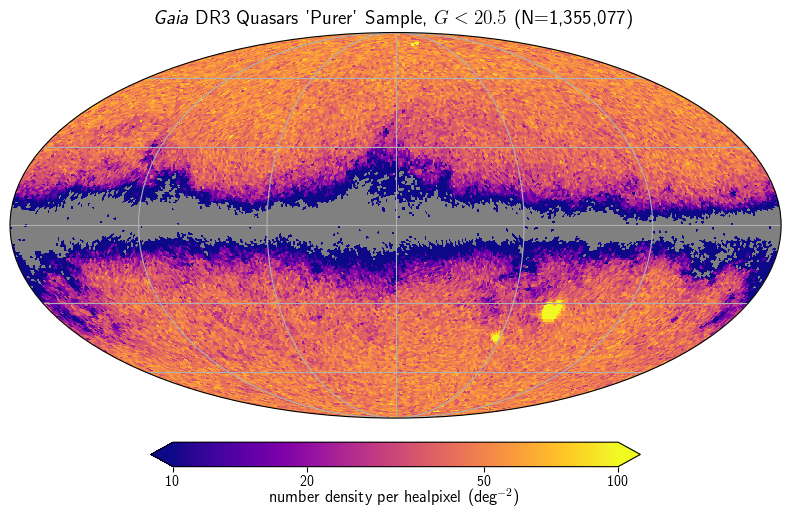

In [19]:
projview(map_gpurer, title=rf"{name_gpurer}, $G<{G_hi}$ (N={len(tab_gpurer_Glim):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=100, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50, 100])
fn = f'{plot_dir}/gpurer_Ghi_2d.png'
if save:
    plt.savefig(fn)

## SDSS DR16Q

In [20]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
print(f"Number of all SDSS quasars: {len(tab_sqall)}")

Number of all SDSS quasars: 638083


In [21]:
idx_Glim_sdss = r_sdss_to_G_gaia(tab_sqall['r_mag_sdss']) < G_hi
print(np.sum(idx_Glim_sdss))

298442


In [22]:
map_sdss = get_map(tab_sqall['ra_sdss'][idx_Glim_sdss], tab_sqall['dec_sdss'][idx_Glim_sdss])

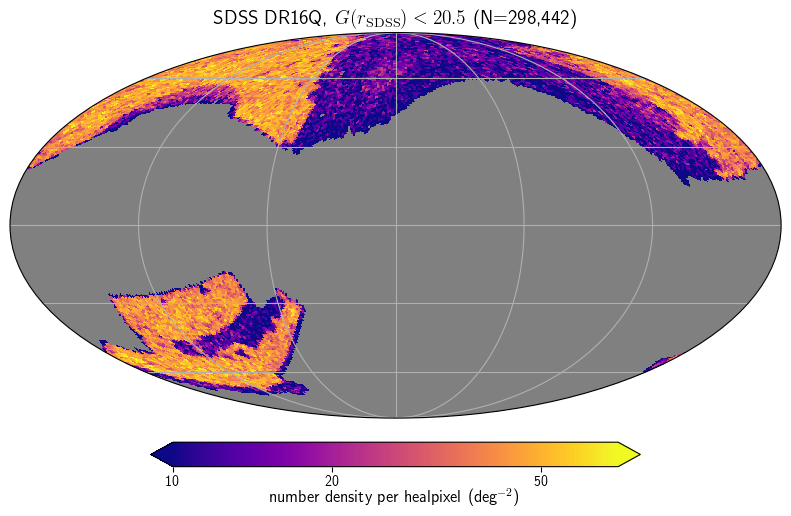

In [23]:
projview(map_sdss, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/sdss_Ghi_2d.png'
if save:
    plt.savefig(fn)

## WISE+PS

In [24]:
# downloaded from zenodo: https://zenodo.org/record/6998864#.ZDM78OzMJhE
fn_wiseps = '/scratch/ksf293/gaia-quasars-lss/data/PS1_WISE_QSO_photoz_catalog.csv'
tab_wiseps = Table.read(fn_wiseps, converters={'EXT': bool})

In [25]:
print(len(tab_wiseps))
idx_reliable = tab_wiseps['EXT']==False
print(np.sum(idx_reliable))

4849634
2879298


Great, matches abstract numbers! 

In [26]:
# documentation
tab_wiseps.columns

<TableColumns names=('objID_PS1','raMean','decMean','w1mpro','w1sigmpro','w1mag','w1sigm','w2mpro','w2sigmpro','w2mag','w2sigm','gFPSFMag','gFPSFMagErr','gFKronMag','gFKronMagErr','rFPSFMag','rFPSFMagErr','rFKronMag','rFKronMagErr','iFPSFMag','iFPSFMagErr','iFKronMag','iFKronMagErr','zFPSFMag','zFPSFMagErr','zFKronMag','zFKronMagErr','yFPSFMag','yFPSFMagErr','yFKronMag','yFKronMagErr','EBV_PS1','EXT','z_pred_mean','z_pred_std','spectroz')>

In [27]:
map_wiseps = get_map(tab_wiseps['raMean'], tab_wiseps['decMean'])

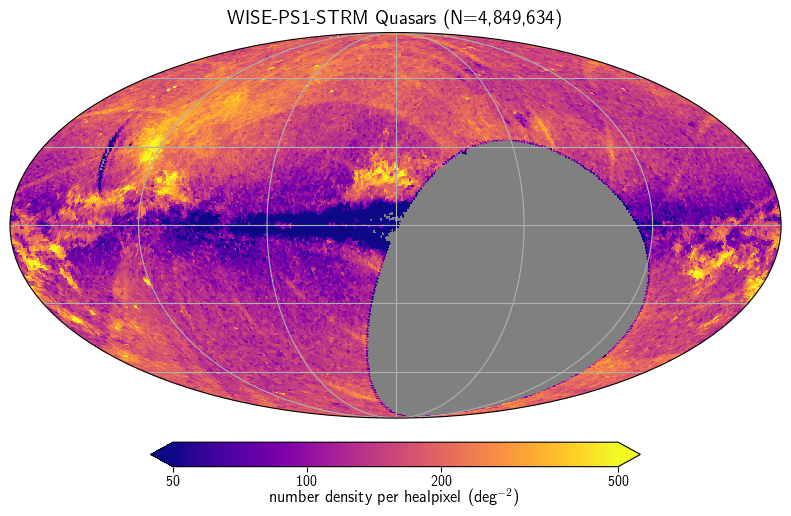

In [28]:
projview(map_wiseps, 
         title=rf"WISE-PS1-STRM Quasars (N={len(tab_wiseps):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=50, max=500, norm='log', graticule=True,
         cbar_ticks=[50, 100, 200, 500])

In [29]:
tab_wiseps_reliable = tab_wiseps[idx_reliable]

In [30]:
map_wiseps = get_map(tab_wiseps_reliable['raMean'], tab_wiseps_reliable['decMean'])

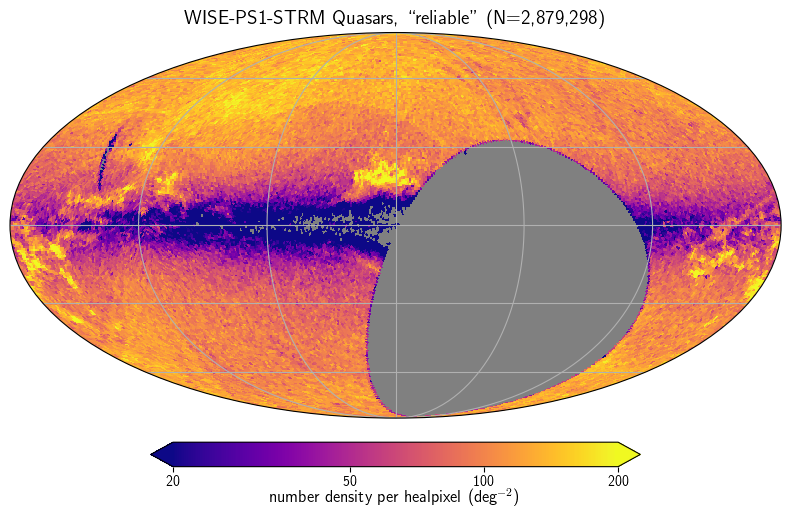

In [31]:
projview(map_wiseps, 
         title=rf"WISE-PS1-STRM Quasars, ``reliable'' (N={len(tab_wiseps[idx_reliable]):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=20, max=200, norm='log', graticule=True,
         cbar_ticks=[20, 50, 100, 200])

In [32]:
# PS1 r magnitude is very similar to SDSS r: https://outerspace.stsci.edu/display/PANSTARRS/PS1+Filter+properties
idx_Glim_wiseps = r_sdss_to_G_gaia(tab_wiseps['rFPSFMag']) < 20.4
print(np.sum(idx_Glim_wiseps))

1361982


In [33]:
tab_wiseps_Glim = tab_wiseps[idx_Glim_wiseps]

In [34]:
map_wiseps = get_map(tab_wiseps_Glim['raMean'], tab_wiseps_Glim['decMean'])

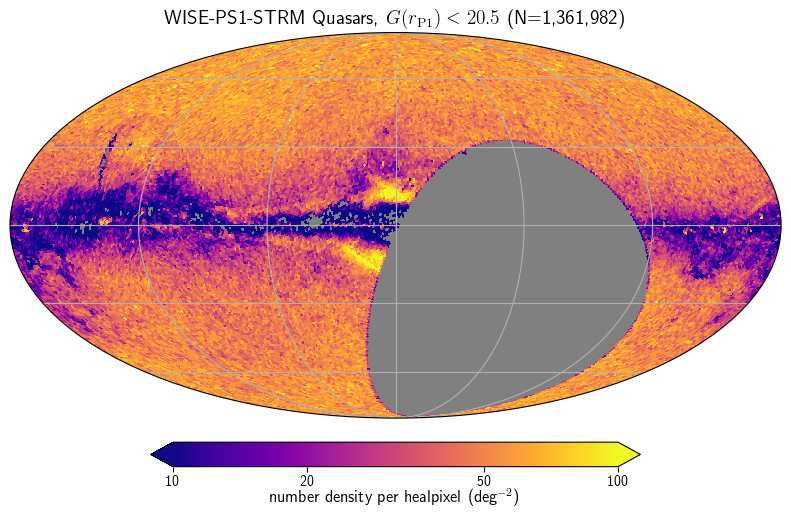

In [35]:
projview(map_wiseps, 
         title=rf"WISE-PS1-STRM Quasars, $G(r_\mathrm{{P1}}) < {G_hi}$ (N={len(tab_wiseps[idx_Glim_wiseps]):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=100, norm='log', graticule=True,
         cbar_ticks=[10, 20, 50, 100])
fn = f'{plot_dir}/wiseps_Ghi_2d.png'
if save:
    plt.savefig(fn)

In [37]:
tab_wiseps_reliable_Glim = tab_wiseps[idx_reliable & idx_Glim_wiseps]

In [38]:
map_wiseps_reliable_Glim = get_map(tab_wiseps_reliable_Glim['raMean'], tab_wiseps_reliable_Glim['decMean'])

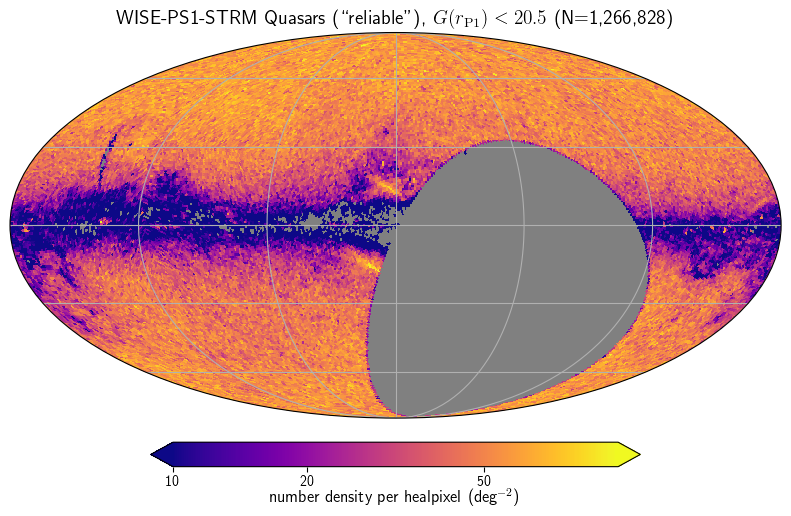

In [39]:
projview(map_wiseps_reliable_Glim, 
         title=rf"WISE-PS1-STRM Quasars (``reliable''), $G(r_\mathrm{{P1}}) < {G_hi}$ (N={len(tab_wiseps[idx_Glim_wiseps & idx_reliable]):,})",
         unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
         min=10, max=100, norm='log', graticule=True,
         cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/wiseps_Ghi_2d.png'
if save:
    plt.savefig(fn)

# Milliquas

In [40]:
fn_mill = '../data/milliquas.fits.zip'
tab_mill = utils.load_table(fn_mill)
print(len(tab_mill))

1453164


In [41]:
print(tab_mill.columns)

<TableColumns names=('RA','DEC','NAME','TYPE','RMAG','BMAG','COMMENT','R','B','Z','CITE','ZCITE','RXPCT','QPCT','XNAME','RNAME','LOBE1','LOBE2')>


RMAG data is heterogeneous - from diff catalogs / filters. So we just use the SDSS conversion and hope it's close enough.

In [42]:
values, counts = np.unique(tab_mill['CITE'], return_counts=True)

ind = np.argpartition(-counts, kth=10)[:10]
for i in ind:
    print(values[i], counts[i])  # prints the 10 most frequent elements
    
print('total:',np.sum(counts))

DR16Q  717418
WISEA  31676
MQ     459068
DR16   43263
2QZ    27534
GAIA3  23730
NBCKv3 26784
XDQSO  21214
PGC    20303
2SLAQ  10367
total: 1453164


In [43]:
idx_Glim_mill = r_sdss_to_G_gaia(tab_mill['RMAG']) < G_hi
print(np.sum(idx_Glim_mill), len(idx_Glim_mill), np.sum(idx_Glim_mill)/len(idx_Glim_mill))
map_ndens_mill = get_map(tab_mill['RA'][idx_Glim_mill], tab_mill['DEC'][idx_Glim_mill])
N = len(tab_mill[idx_Glim_mill])

912050 1453164 0.6276304670360675


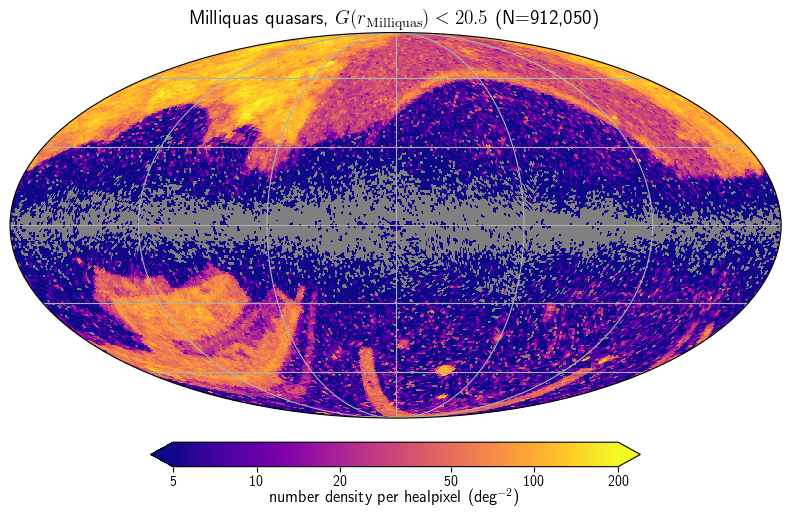

In [44]:
projview(map_ndens_mill, title=rf"Milliquas quasars, $G(r_\mathrm{{Milliquas}})<{G_hi}$ (N={N:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=5, max=200, norm='log', graticule=True,
            cbar_ticks=[5, 10, 20, 50, 100, 200])

fn = f'{plot_dir}/milliquas_Ghi_2d.png'
if save:
    plt.savefig(fn, bbox_inches='tight')

## eBOSS

In [45]:
fn_eboss = '../data/eBOSS_QSO_full_ALLdata-vDR16_changecolname.fits'
tab_eboss = Table.read(fn_eboss)
print(f"Number of eboss quasars: {len(tab_eboss)}")

Number of eboss quasars: 655521


In [46]:
# ugriz, so r is 2
r_mag_eboss = tab_eboss['MODELMAG'][:,2]

In [47]:
i_imatch = (tab_eboss['IMATCH']==1) | (tab_eboss['IMATCH']==2)
print(np.sum(i_imatch))

i_comp = (tab_eboss['COMP_BOSS']>0.5)
i_sect = (tab_eboss['sector_SSR']>0.5)
print(np.sum(i_comp), np.sum(i_sect))
print(np.sum(i_comp & i_sect))

i_clust = i_imatch & i_comp & i_sect
print(np.sum(i_clust))

i_zwarning0 = tab_eboss['ZWARNING']==0
tab_eboss_good = tab_eboss[i_clust & i_zwarning0]

454452
538994 567466
538628
452531


In [48]:
i_Glim_eboss = r_sdss_to_G_gaia(r_mag_eboss) < G_hi
print(np.sum(i_Glim_eboss))

284273


In [53]:
tab_eboss_Glim = tab_eboss[i_clust & i_zwarning0 & i_Glim_eboss]

In [54]:
map_eboss = get_map(tab_eboss_Glim['RA'], 
                    tab_eboss_Glim['DEC'])

In [55]:
N_eboss = len(tab_eboss_Glim)

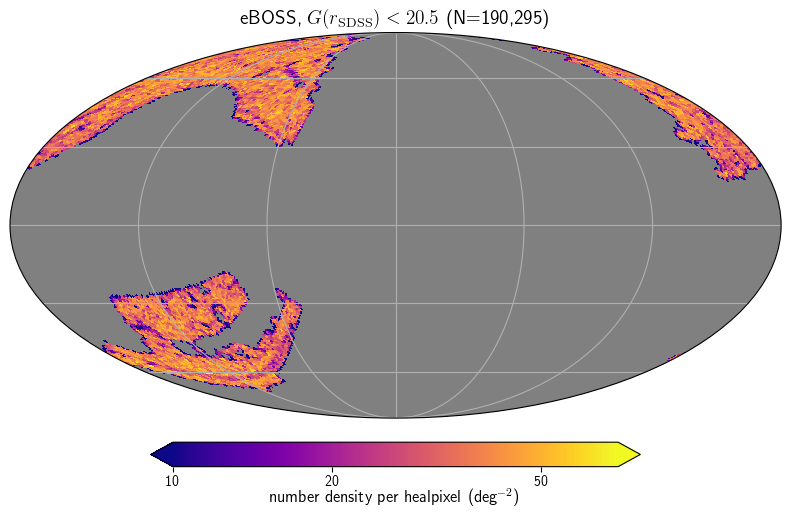

In [56]:
projview(map_eboss, title=rf"eBOSS, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={N_eboss:,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])
fn = f'{plot_dir}/eboss_Ghi_2d.png'
if save:
    plt.savefig(fn)

# Catalog quantities

### Numbers

In [242]:
frac_reliable = np.sum(idx_reliable)/len(idx_reliable)
p_reliable = round(100*frac_reliable)
quants['p_reliable_wiseps'] = p_reliable

### Redshifts

In [34]:
idx_has_specz = tab_wiseps['spectroz']!=-999
print(np.sum(idx_has_specz))

328677


In [153]:
def print_z_err_info(zs, zs_withspec, zs_spec):
    print(f"Median z: {np.median(zs):.3f}")
    
    threshs = [0.01, 0.1, 0.2, 0.5]
    dz = (zs_withspec - zs_spec)/(1 + zs_spec)
    n_tot = len(zs_spec)
    for thresh in threshs:
        n_below = np.sum(np.abs(dz) < thresh)
        print(fr'$f(|dz|<{thresh}) = {n_below/n_tot:.3f}$')

In [36]:
print_z_err_info(tab_wiseps['z_pred_mean'], 
                 tab_wiseps['z_pred_mean'][idx_has_specz], 
                 tab_wiseps['spectroz'][idx_has_specz])

Median z: 1.599
$f(|dz|<0.01) = 0.108$
$f(|dz|<0.1) = 0.706$
$f(|dz|<0.2) = 0.876$
$f(|dz|<0.5) = 0.982$


In [37]:
print_z_err_info(tab_wiseps['z_pred_mean'][idx_reliable], 
                 tab_wiseps['z_pred_mean'][idx_reliable&idx_has_specz], 
                 tab_wiseps['spectroz'][idx_reliable&idx_has_specz])

Median z: 1.411
$f(|dz|<0.01) = 0.110$
$f(|dz|<0.1) = 0.711$
$f(|dz|<0.2) = 0.880$
$f(|dz|<0.5) = 0.983$


In [154]:
idx_has_specz = tab_wiseps_reliable_Glim['spectroz']!=-999

print_z_err_info(tab_wiseps_reliable_Glim['z_pred_mean'], 
                 tab_wiseps_reliable_Glim['z_pred_mean'][idx_has_specz], 
                 tab_wiseps_reliable_Glim['spectroz'][idx_has_specz])

Median z: 1.431
$f(|dz|<0.01) = 0.123$
$f(|dz|<0.1) = 0.763$
$f(|dz|<0.2) = 0.908$
$f(|dz|<0.5) = 0.985$


In [170]:
print(tab_sq['source_id'].mask)

[False  True  True ... False False False]


In [173]:
tab_sq = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall.csv', format='csv')
print(tab_sq.columns)
tab_sq.rename_column('t1_source_id', 'source_id')
tab_sq.rename_column('t1_z', 'z_sdss')
print(f"Number of SDSS xgaiaall quasars: {len(tab_sq)}")
tab_sq.keep_columns(['source_id', 'z_sdss'])
tab_gpurer_Glim_lite = tab_gpurer_Glim.copy()
tab_gpurer_Glim_lite.keep_columns(['source_id', 'redshift_qsoc'])

# remove sq objects with no gaia source_id
tab_sq = tab_sq[~tab_sq['source_id'].mask]
tab_gpurer_xsq = join(tab_gpurer_Glim_lite, tab_sq, keys='source_id', join_type='inner')
print(len(tab_gpurer_xsq))

<TableColumns names=('t1_ra','t1_dec','t1_source_id','t1_ra_sdss','t1_dec_sdss','t1_objid','t1_z','t1_phot_g_mean_mag','t1_phot_bp_mean_mag','t1_phot_rp_mean_mag','t1_phot_bp_n_obs','t1_phot_rp_n_obs','dec','mag_w1_vg','mag_w2_vg','ra','unwise_objid','dist_arcsec')>
Number of SDSS xgaiaall quasars: 638089
235869


In [155]:
dz_threshs = {'dzlo': 0.01, 'dzmid': 0.1, 'dzhi': 0.2}

In [159]:
zs_withspec = tab_wiseps_reliable_Glim['z_pred_mean'][idx_has_specz]
zs_spec = tab_wiseps_reliable_Glim['spectroz'][idx_has_specz]

for table in tables:
    dz = (zs_withspec - zs_spec)/(1 + zs_spec)
    n_tot = len(zs_spec)
    for dz_name, dz_thresh in dz_threshs.items():
        n_below = np.sum(np.abs(dz) < dz_thresh)
        frac = n_below/n_tot
        val = f"{100*frac:.0f}"
        quants[f'p_acc_{dz_name}_wiseps'] = val
        print(dz_thresh, quants[f'p_acc_{dz_name}_wiseps'])

0.01 12
0.1 76
0.2 91


In [161]:
tab_gpurer_Glim.columns

<TableColumns names=('source_id','ra','dec','l','b','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_g_n_obs','phot_bp_n_obs','phot_rp_n_obs','redshift_qsoc','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','pmra','pmra_error','pmdec','pmdec_error','parallax','parallax_error','ebv','A_v','pm','mag_w1_vg','mag_w2_vg','unwise_objid','rand_ints')>

### Volumes

In [75]:
def v_shells_of_z(z_bins, fsky, cosmo):
    
    v_at_z_bins = np.empty(len(z_bins), dtype=u.Quantity)
    for i in range(len(z_bins)):
        v = cosmo.comoving_volume(z_bins[i])
        v_at_z_bins[i] = v.to(u.Gpc**3)
    v_at_z_bins *= fsky
    v_shells = v_at_z_bins[1:] - v_at_z_bins[:-1] 

    return np.array(v_shells)

In [76]:
def ndens_of_z(z_arr, z_bins, fsky, cosmo):
    
    v_shells = v_shells_of_z(z_bins, fsky, cosmo)
    ndens = []
    for i in range(len(z_bins)-1):
        N_inbin = np.sum((z_arr >= z_bins[i]) & (z_arr < z_bins[i+1]))
        ndens_inbin = N_inbin/v_shells[i]
        ndens.append(ndens_inbin)
    return ndens

In [77]:
# eqn 1.7.32 of https://arxiv.org/pdf/1606.00180.pdf
def volume_effective_Gpcperh(z_arr, z_bins, cosmo, fsky, P0):
    
    ndens_at_z_bins = ndens_of_z(z_arr, z_bins, fsky, cosmo)
    ndens_at_z_bins = np.array(ndens_at_z_bins, dtype=u.Quantity)

    nPs = np.array([n*P0 for n in ndens_at_z_bins])
    prefacs = (nPs /(1 + nPs))**2
    v_shells = v_shells_of_z(z_bins, fsky, cosmo)    
    v_Gpc = np.sum(prefacs*v_shells)

    v_Gpc = v_Gpc.to(u.Gpc**3) # this should be just in Gpc
    v_Gpcperh = v_Gpc * cosmo.h**3 # (Gpc) -> (Gpc/h)^3, mult by h^3 
    print(f"Sky fraction is {fsky:.3f}")
    print(f"Effective volume is {v_Gpc:.3f} = {v_Gpcperh.value:.3f} (Gpc/h)^3")
    return v_Gpcperh.value

In [73]:
from astropy.cosmology import Planck18
cosmo = Planck18
area_allsky = 41252.96125#*(u.deg**2)
P0 = 4e4 * u.Mpc**3 / cosmo.h**3 

In [243]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = maps.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Av_hi = 0.5
quants['Avhi'] = Av_hi

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


In [65]:
fn_gcathi = f'../data/catalog_G{G_hi}.fits'
tab_gcathi = utils.load_table(fn_gcathi)
print(len(tab_gcathi))

1295502


In [228]:
fn_gcatlo = f'../data/catalog_G{G_lo}.fits'
tab_gcatlo = utils.load_table(fn_gcatlo)
print(len(tab_gcatlo))

755850


In [180]:
tab_sq = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall.csv', format='csv')
tab_sq.rename_column('t1_source_id', 'source_id')
tab_sq.rename_column('t1_z', 'z_sdss')
print(f"Number of SDSS xgaiaall quasars: {len(tab_sq)}")
tab_sq.keep_columns(['source_id', 'z_sdss'])
# remove sq objects with no gaia source_id
tab_sq = tab_sq[~tab_sq['source_id'].mask]

Number of SDSS xgaiaall quasars: 638089


In [229]:
tab_gpurer_Glim = join(tab_gpurer_Glim, tab_sq, keys='source_id', join_type='left')
tab_gcathi = join(tab_gcathi, tab_sq, keys='source_id', join_type='left')
tab_gcatlo = join(tab_gcatlo, tab_sq, keys='source_id', join_type='left')

In [230]:
tables_Glim = {'eboss': tab_eboss_Glim,
                 'gcathi': tab_gcathi,
               'gcatlo': tab_gcatlo,
                 'wiseps': tab_wiseps_reliable_Glim,
                 'gpurer': tab_gpurer_Glim
                }

zlabels = {'eboss': 'Z',
             'gcathi': 'redshift_spz',
             'gcatlo': 'redshift_spz',
             'wiseps': 'z_pred_mean',
             'gpurer': 'redshift_qsoc'
            }

zspec_labels = {'gcathi': 'z_sdss',
                'gcatlo': 'z_sdss',
             'wiseps': 'spectroz',
             'gpurer': 'z_sdss'
            }

survey_names = {'eboss': 'eBOSS',
                 'gcathi': 'QUaia',
                 'gcatlo': 'QUaia ($G<20.0$)',
                 'wiseps': 'WISE-PS1',
                 'gpurer': '\emph{Gaia} Purer'
                }

radec_names = {'eboss': ['RA', 'DEC'],
                 'gcathi': ['ra', 'dec'],
                 'gcatlo': ['ra', 'dec'],
                 'wiseps': ['raMean', 'decMean'],
                 'gpurer': ['ra', 'dec']
                }

In [244]:
tnames = ['gcathi', 'gcatlo', 'gpurer', 'wiseps', 'eboss']
N_arr, area_arr, nbar_arr, fsky_arr, veff_arr, vspan_arr, zmed_arr = [], [], [], [], [], [], []
for name in tnames:
    table = tables_Glim[name]
    ra_name, dec_name = radec_names[name]
    pixel_indices = hp.ang2pix(NSIDE, table[ra_name], table[dec_name], lonlat=True)
    NPIX = hp.nside2npix(NSIDE)
    counts_by_pixel = np.bincount(pixel_indices, minlength=NPIX)
    i_keep = (map_dust[pixel_indices] < Av_hi) & (counts_by_pixel[pixel_indices]>0)
    i_pix_keep = (map_dust < Av_hi) & (counts_by_pixel>0)
    print(np.sum(i_keep), len(i_keep))
    table = table[i_keep]
    
    N = len(table)
    quants[f'N_{name}'] = rf'{N:,}'
    
    #area = areas[name]
    area = np.sum(i_pix_keep) * area_per_pixel 
    quants[f'area_{name}'] = rf'{area:.2f} deg$^2$'
    fsky = area/area_allsky
    quants[f'fsky_{name}'] = f'{fsky:.2f}'
    
    nbar = len(table)/area
    quants[f'nbar_{name}'] = rf'{nbar:.2f} deg$^{-2}$'

    z_arr = table[zlabels[name]]
    z_min, z_max = np.min(z_arr), np.max(z_arr)
    z_bins = np.arange(0, z_max+0.1, 0.1)

    vol = volume_effective_Gpcperh(z_arr, z_bins, cosmo, fsky, P0)
    vol_fmt = rf'{vol:.2f} $(h^{{-1}}\,Gpc)^3$'
    quants[f'volume_effective_{name}'] = vol_fmt
    
    z_range = [0.8, 2.2]
    vol_span = v_shells_of_z(z_range, fsky, cosmo)[0]
    vol_span = (vol_span.to(u.Gpc**3) * cosmo.h**3).value # (Gpc) -> (Gpc/h)^3, mult by h^3 
    print(vol_span)
    vol_span_fmt = rf'{vol_span:.2f} $(h^{{-1}}\,Gpc)^3$'
    quants[f'volume_spanning_{name}'] = vol_span_fmt
        
    N_arr.append(f'{N:,}')
    area_arr.append(f'{area:.2f}')
    nbar_arr.append(f'{nbar:.2f}')
    fsky_arr.append(f'{fsky:.2f}')
    veff_arr.append(f'{vol:.2f}')
    vspan_arr.append(f'{vol_span:.2f}')
    #zmed_arr.append(f'{zmed:.2f}')
     #     print(quants[f'N_{name}'])
#     print(quants[f'area_{name}'])
#     print(quants[f'nbar_{name}'])
#     print(quants[f'fsky_{name}'])
#     print(quants[f'volume_effective_{name}'])
#     print(quants[f'volume_spanning_{name}'])
#     print(quants[f'zmed_{name}'])
#     print()

1209839 1295509
Sky fraction is 0.707
Effective volume is 22.638 Gpc3 = 7.012 (Gpc/h)^3
138.45576837453785
705365 755851
Sky fraction is 0.707
Effective volume is 9.347 Gpc3 = 2.895 (Gpc/h)^3
138.45576837453785
1261890 1355084
Sky fraction is 0.707
Effective volume is 20.763 Gpc3 = 6.431 (Gpc/h)^3
138.43583865200583
1106010 1266828
Sky fraction is 0.538
Effective volume is 23.265 Gpc3 = 7.206 (Gpc/h)^3
105.44816191698526
190194 190295
Sky fraction is 0.135
Effective volume is 3.254 Gpc3 = 1.008 (Gpc/h)^3
26.546390412667613


### Number density as func of redshift

In [1]:
z_bins = np.arange(0.0, 6.0, 0.1)
z_bins_avg = 0.5*(z_bins[:-1] + z_bins[1:])

for name in tnames:
    table = tables_Glim[name]
    z_arr = table[zlabels[name]]
    ndens_at_z_bins = ndens_of_z(z_arr, z_bins, fskys[name], cosmo)
    ndens_at_z_bins_vals = np.array([(n.to(1/u.Mpc**3)/(cosmo.h**3)).value for n in ndens_at_z_bins])
    #plt.hist(z_arr, bins=z_bins, histtype='step', label=name)
    
    plt.plot(z_bins_avg, ndens_at_z_bins_vals*1e5, label=name)
plt.legend()
plt.ylim(0,2)

plt.axhline(0.1, ls='--', color='grey')

NameError: name 'np' is not defined

eBOSS without cuts, to verify amplitude

In [ ]:
z_bins = np.arange(0.0, 6.0, 0.1)
z_bins_avg = 0.5*(z_bins[:-1] + z_bins[1:])

z_arr = tab_eboss_clust['Z']
ndens_at_z_bins = ndens_of_z(z_arr, z_bins, fskys[name], cosmo)
ndens_at_z_bins_vals = np.array([(n.to(1/u.Mpc**3)/(cosmo.h**3)).value for n in ndens_at_z_bins])
#plt.hist(z_arr, bins=z_bins, histtype='step', label=name)

plt.plot(z_bins_avg, ndens_at_z_bins_vals*1e5)
plt.legend()
plt.ylim(0,2)

plt.axhline(0.1, ls='--', color='grey')

### Redshifts

In [245]:
zmed_arr, f01_arr, f001_arr = [], [], []
for name in tnames:
    table = tables_Glim[name]
    z_arr = table[zlabels[name]]

    zmed = np.median(z_arr)
    zmed_arr.append(f'{zmed:.2f}')
    quants[f'zmed_{name}'] = rf'{zmed:.2f}'
   
    if name in zspec_labels:
        z_spec = table[zspec_labels[name]]
        if name=='wiseps':
            i_has_zspec = table[zspec_labels[name]]!=-999
        else:
            i_has_zspec = ~table[zspec_labels[name]].mask
        z_spec = table[zspec_labels[name]][i_has_zspec]
        z_est = z_arr[i_has_zspec]

        dz = (z_est - z_spec)/(1 + z_spec)
        n_tot = len(dz)

        n_below = np.sum(np.abs(dz) < 0.01)
        f001 = f'{n_below/n_tot:.2f}'
        f001_arr.append(f001)

        n_below = np.sum(np.abs(dz) < 0.1)
        f01 = f'{n_below/n_tot:.2f}'
        f01_arr.append(f01)
        
        quants[f'frac_acc_dzlo_{name}'] = f001
        quants[f'frac_acc_dzmid_{name}'] = f01
        
    else: 
        f001_arr.append('')
        f01_arr.append('')

/ext3/miniconda3/envs/gaiaenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [233]:
table_table = Table([tnames, N_arr, area_arr, nbar_arr, fsky_arr, veff_arr, vspan_arr, zmed_arr, f001_arr, f01_arr], 
                    names=('tname', 'N', 'area', 'nbar', 'fsky', 'volume_effective', 'volume_spanning', 
                           'zmed','f001','f01'))

In [234]:
column_labels = {'N': r'$N$', 
                'fsky': r'$f_\text{sky}$',
                #'nbar': r'$\bar{n}$ [deg$^{-2}$]', 
                 'nbar': r'\makecell{$\bar{n},$\\$\text{deg}^{-2}$}',
                'volume_spanning': r'\makecell{$V_\text{span},$\\$(h^{-1}\,\text{Gpc})^3$}',
                'volume_effective': r'\makecell{$V_\text{eff},$\\$(h^{-1}\,\text{Gpc})^3$}', 
                'zmed': r'$z_\text{med}$',
                'survey_name': '',
                'f001': r'\makecell{$f(|\delta z|$\\$<0.01)$}',
                'f01': r'\makecell{$f(|\delta z|$\\$<0.1)$}'
                }

In [250]:
quant_names = ['N', 'fsky', 'nbar', 'volume_spanning', 'volume_effective', 'zmed', 'f001', 'f01']
table_column_names = ['survey_name'] + quant_names

table_contents = '\\begin{tabular}'
table_contents += '{|'+'|'.join(['l' for _ in table_column_names]) + '|}\n'
table_contents += '\hline\n'
table_contents += ' & '.join(column_labels[tc] for tc in table_column_names) + ' \\\\\n'
table_contents += '\hline\n'

tnames_show = ['gcathi', 'gpurer', 'wiseps', 'eboss']
table_table.add_index('tname')
for tname in tnames_show:
    #i = table_table.loc[tname]
    #print(i)
    row_vals = [str(table_table.loc[tname][qn]) for qn in quant_names]
    #row_vals = [quants[f'{qn}_{tname}'] for qn in quant_names]
    row_vals = [survey_names[tname]] + row_vals
    if tname=='gcathi':
        row_vals = [f'\\textbf{{{rv}}}' for rv in row_vals]
    row = ' & '.join(row_vals) + ' \\\\\n'
#     if i<len(table_table)-1:
#         row += ' \\\\ \n'
    #print(row,end='') # end makes print not print an additional newline
    table_contents += row
table_contents += '\hline\n'
table_contents += '\end{tabular}'
print(table_contents)    

\begin{tabular}{|l|l|l|l|l|l|l|l|l|}
\hline
 & $N$ & $f_\text{sky}$ & \makecell{$\bar{n},$\\$\text{deg}^{-2}$} & \makecell{$V_\text{span},$\\$(h^{-1}\,\text{Gpc})^3$} & \makecell{$V_\text{eff},$\\$(h^{-1}\,\text{Gpc})^3$} & $z_\text{med}$ & \makecell{$f(|\delta z|$\\$<0.01)$} & \makecell{$f(|\delta z|$\\$<0.1)$} \\
\hline
\textbf{QUaia} & \textbf{1,209,839} & \textbf{0.71} & \textbf{41.50} & \textbf{138.46} & \textbf{7.01} & \textbf{1.47} & \textbf{0.61} & \textbf{0.83} \\
\emph{Gaia} Purer & 1,261,890 & 0.71 & 43.29 & 138.44 & 6.43 & 1.61 & 0.62 & 0.70 \\
WISE-PS1 & 1,106,010 & 0.54 & 49.81 & 105.45 & 7.21 & 1.43 & 0.12 & 0.76 \\
eBOSS & 190,194 & 0.14 & 34.03 & 26.55 & 1.01 & 1.49 &  &  \\
\hline
\end{tabular}


In [251]:
fn_table = '../data/comparison_table.txt'
with open(fn_table, 'w') as f:
    if save:
        f.write(table_contents)
if save:
    print(f"Saved to {fn_table}!")

Saved to ../data/comparison_table.txt!


# Investigating SDSS

In [38]:
np.min(map_sdss)

1.1914781026947956

In [39]:
npix_nonzero_sdss = np.sum(map_sdss>0)

In [40]:
area_sdss = npix_nonzero_sdss*area_per_pixel
print(area_sdss)

10596.921564436192


In [41]:
len(map_sdss)

49152

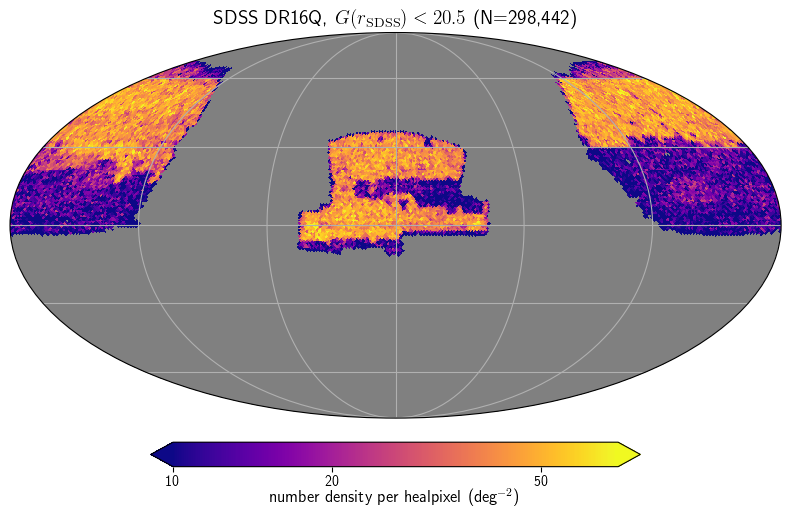

In [42]:
projview(map_sdss, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map,# coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])

In [43]:
idx_zmain = (tab_sqall['z_sdss'] > 0.8) & (tab_sqall['z_sdss'] < 3.5)

In [44]:
map_sdss_zmain = get_map(tab_sqall['ra_sdss'][idx_zmain], tab_sqall['dec_sdss'][idx_zmain])

In [45]:
np.min(map_sdss_zmain)

1.1914781026947956

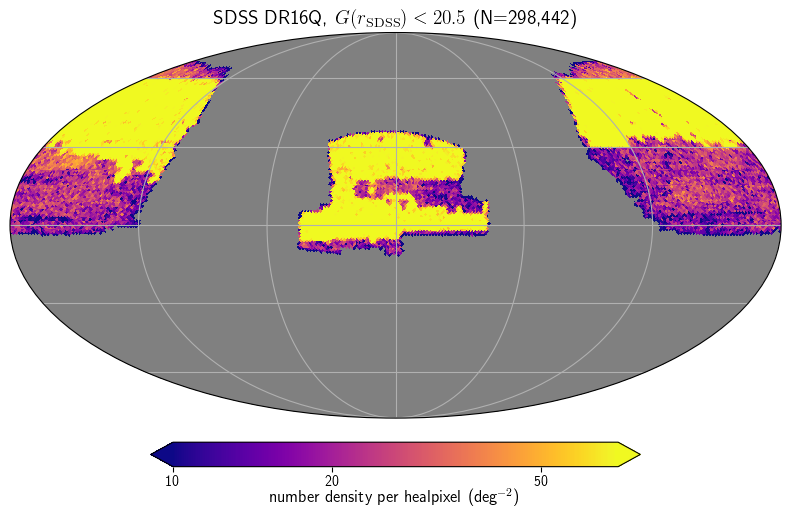

In [46]:
projview(map_sdss_zmain, title=rf"SDSS DR16Q, $G(r_\mathrm{{SDSS}})<{G_hi}$ (N={len(tab_sqall[idx_Glim_sdss]):,})",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map,# coord=['C', 'G'], 
            min=10, max=70, norm='log', graticule=True,
            cbar_ticks=[10, 20, 50])

In [82]:
tab_sdss = utils.load_table('../data/SDSS_DR16Q_v4.fits')

In [83]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

In [84]:
i_sdssiv = tab_sdss['MJD'] > 56898 # from lyke paper fig 2
print(np.sum(i_sdssiv), len(i_sdssiv))

387021 750414


In [85]:
i_zwarning0 = tab_sdss['ZWARNING'] == 0
print(np.sum(i_zwarning0), len(i_zwarning0))

638022 750414


In [86]:
print(np.sum(i_sdssiv & i_zwarning0))

362056


# eBOSS LSS QSO catalogs

In [47]:
fn_eboss_ngc = '../data/eBOSS_QSO_clustering_data-NGC-vDR16.fits'
fn_eboss_sgc = '../data/eBOSS_QSO_clustering_data-SGC-vDR16.fits'

tab_eboss_ngc = Table.read(fn_eboss_ngc)
tab_eboss_sgc = Table.read(fn_eboss_sgc)
print(len(tab_eboss_ngc))
print(len(tab_eboss_sgc))
print(len(tab_eboss_ngc)+len(tab_eboss_sgc))
print(tab_eboss_ngc.columns)
print(tab_eboss_sgc.columns)

218209
125499
343708
<TableColumns names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ','QSO_ID')>
<TableColumns names=('RA','DEC','Z','WEIGHT_FKP','WEIGHT_SYSTOT','WEIGHT_CP','WEIGHT_NOZ','NZ','QSO_ID')>


In [18]:
print(np.min(tab_eboss_ngc['Z']), np.max(tab_eboss_ngc['Z']))
print(np.min(tab_eboss_sgc['Z']), np.max(tab_eboss_sgc['Z']))

0.8000152398143878 2.199999421096105
0.8000400779130542 2.1999820553107012


In [19]:
fn_eboss = '../data/eBOSS_QSO_full_ALLdata-vDR16_changecolname.fits'
tab_eboss = Table.read(fn_eboss)
print(len(tab_eboss))
print(tab_eboss.columns)
print(np.min(tab_eboss['Z']), np.max(tab_eboss['Z']))

655521
<TableColumns names=('RUN','CAMCOL','FIELD','ID','RERUN','FIBER2MAG','RA','DEC','PSFFLUX','PSFFLUX_IVAR','EXTINCTION','FIBER2FLUX','FIBER2FLUX_IVAR','MODELFLUX','MODELFLUX_IVAR','MODELMAG','W1_MAG','W1_MAG_ERR','W1_NANOMAGGIES','W1_NANOMAGGIES_IVAR','W2_NANOMAGGIES','W2_NANOMAGGIES_IVAR','OBJID_TARGETING','CHUNK','TILE','LOCATIONID','NTILES','BOSSTILE_STATUS','TRIMMED','IDUPLICATE','IGEOMETRY','INGROUP','FIRSTGROUP','MULTGROUP','NEXTGROUP','SECTOR','QSO_ID','IMATCH','Z','PLATE','FIBERID','MJD','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','IS_QSO_FINAL','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','DELTACHI2_MGII','AUTOCLASS_PQN','RANDOM_SELECT','Z_10K','IS_QSO_10K','PRIM_REC','Z_VI','ZWARNING','Z_PCA','XFOCAL','YFOCAL','PLATESN2','SN_MEDIAN_ALL','SPEC1_G','SPEC1_R','SPEC1_

In [21]:
print(np.sum(tab_eboss['IS_QSO_FINAL']))

155960


In [39]:
print(np.sum(tab_eboss['ZWARNING']==0))
print(np.sum(tab_eboss['ZWARNING']!=0))
print(np.sum(tab_eboss['ZWARNING'].mask))
print(np.sum(~tab_eboss['ZWARNING'].mask))
print(set(np.array(tab_eboss['ZWARNING'])))

475863
43130
136528
518993
{0, 64, 256, 128, 4, 68, 646, 134, 192, -1, 999999}


In [41]:
print(np.sum(tab_eboss['Z']==0))
print(np.sum(tab_eboss['Z']!=0))
print(np.sum(tab_eboss['Z']<0))
print(np.sum((tab_eboss['Z']>0.8) & (tab_eboss['Z']<2.2)))

110636
544885
8244
375293


In [71]:
print(np.sum((tab_eboss['Z']!=0) & (tab_eboss['ZWARNING']==0)))
i_goodz = (tab_eboss['Z']!=0) & (tab_eboss['ZWARNING']==0)
print(np.sum((tab_eboss['Z'][i_goodz]>0.8) & (tab_eboss['Z'][i_goodz]<2.2)))                                 

475863
323959


In [90]:
i_zwarning0 = tab_eboss['ZWARNING']==0
print(np.sum((tab_eboss['Z'][i_zwarning0]>0.8) & (tab_eboss['Z'][i_zwarning0]<2.2)))

323959


In [64]:
i_zwarning0_ormasked = (tab_eboss['ZWARNING']==0) | (~tab_eboss['ZWARNING'].mask)
print(np.sum((tab_eboss['Z'][i_zwarning0_ormasked]>0.8) & (tab_eboss['Z'][i_zwarning0_ormasked]<2.2)))

352089


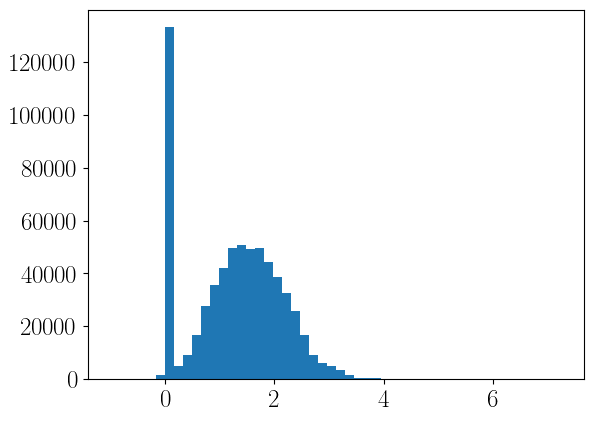

In [26]:
_ = plt.hist(tab_eboss['Z'], bins=50)

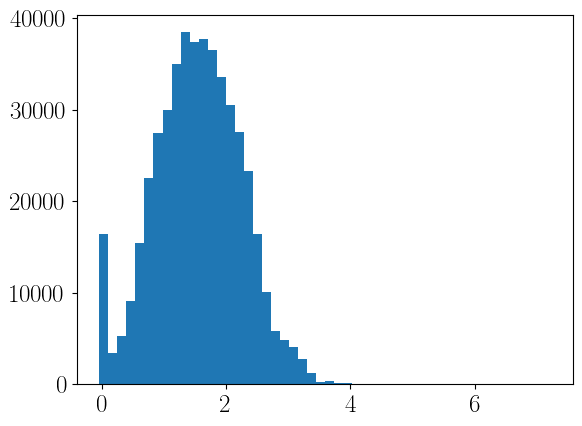

In [66]:
_ = plt.hist(tab_eboss['Z'][i_zwarning0], bins=50)

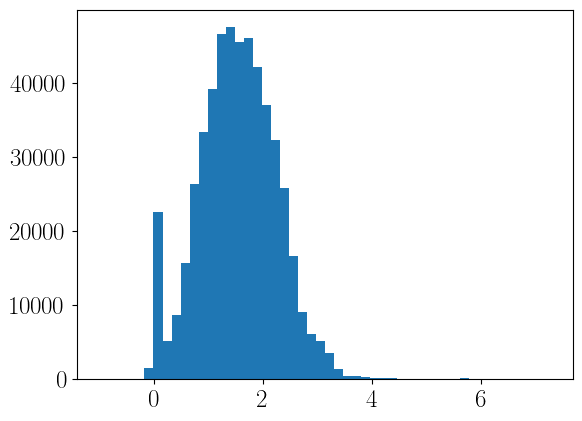

In [65]:
_ = plt.hist(tab_eboss['Z'][i_zwarning0_ormasked], bins=50)

In [74]:
print(len(tab_eboss))

655521


In [72]:
i_imatch = (tab_eboss['IMATCH']==1) | (tab_eboss['IMATCH']==2)
print(np.sum(i_imatch))
print(np.sum((tab_eboss['Z'][i_imatch]>0.8) & (tab_eboss['Z'][i_imatch]<2.2)))

454452
345083


In [75]:
i_comp = (tab_eboss['COMP_BOSS']>0.5)
i_sect = (tab_eboss['sector_SSR']>0.5)
print(np.sum(i_comp), np.sum(i_sect))
print(np.sum(i_comp & i_sect))
print(np.sum((tab_eboss['Z'][i_comp & i_sect]>0.8) & (tab_eboss['Z'][i_comp & i_sect]<2.2)))

538994 567466
538628
363159


In [77]:
i_rezaie = i_imatch & i_comp & i_sect
print(np.sum(i_rezaie))
print(np.sum((tab_eboss['Z'][i_rezaie]>0.8) & (tab_eboss['Z'][i_rezaie]<2.2)))

452531
343708


In [87]:
print(np.min(tab_eboss['Z']), np.max(tab_eboss['Z']))
print(np.min(tab_eboss['Z'][i_rezaie]), np.max(tab_eboss['Z'][i_rezaie]))

-1.0 7.267529604204124
-1.0 7.2599769230277245


In [91]:
print(np.min(tab_eboss['Z']), np.max(tab_eboss['Z']))
print(np.min(tab_eboss['Z'][i_rezaie & i_zwarning0]), np.max(tab_eboss['Z'][i_rezaie & i_zwarning0]))

-1.0 7.267529604204124
-0.033842958308976254 7.217512646444396


In [92]:
print(np.sum((tab_eboss['Z'][i_rezaie & i_zwarning0]>0.8) & (tab_eboss['Z'][i_rezaie & i_zwarning0]<2.2)))

306005


In [94]:
tab_sqall = utils.load_table(f'../data/quasars_sdss_xgaiaall_xunwiseall_good.fits')
tab_sqall.columns

<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','objid','z_sdss','thing_id','u_mag_sdss','g_mag_sdss','r_mag_sdss','i_mag_sdss','z_mag_sdss','u_mag_err_sdss','g_mag_err_sdss','r_mag_err_sdss','i_mag_err_sdss','z_mag_err_sdss','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs','dec_unwise','mag_w1_vg','mag_w2_vg','ra_unwise','unwise_objid','dist_arcsec')>

In [95]:
print(np.min(tab_eboss['Z']), np.max(tab_eboss['Z']))
print(np.min(tab_sqall['z_sdss']), np.max(tab_sqall['z_sdss']))

-1.0 7.267529604204124
0.017309146001935005 7.023917198181152


In [113]:
N_sdss = len(tab_sqall['z_sdss'])
print(N_sdss)
N_eboss = len(tab_eboss['Z'][i_rezaie])
N_eboss_zwarning0 = len(tab_eboss['Z'][i_rezaie & i_zwarning0])

638083


In [147]:
len(tab_eboss), len(tab_eboss[i_rezaie]), len(tab_eboss[i_rezaie & i_zwarning0])

(655521, 452531, 409341)

In [134]:
tab_joined = join(tab_eboss, tab_sdss, keys=('PLATE', 'MJD', 'FIBERID'), join_type='inner')
print(len(tab_joined))

484843


In [141]:
tab_joined_rezaie = join(tab_eboss[i_rezaie], tab_sdss, keys=('PLATE', 'MJD', 'FIBERID'), join_type='inner')
print(len(tab_joined_rezaie))

451238


In [148]:
tab_joined_rezaie_zwarning0 = join(tab_eboss[i_rezaie & i_zwarning0], tab_sdss, keys=('PLATE', 'MJD', 'FIBERID'), join_type='inner')
print(len(tab_joined_rezaie_zwarning0))

408267


In [144]:
print(np.sum((tab_joined_rezaie['Z_1']>0.8) & (tab_joined_rezaie['Z_1']<2.2)))

343141


In [137]:
i_spec = np.isin(tab_eboss['OBJID_TARGETING'], tab_joined['OBJID_TARGETING'])
print(np.sum(i_spec), len(i_spec))

512475 655521


In [140]:
len(np.unique(tab_eboss['OBJID_TARGETING']))

517922

Text(0, 0.5, 'number (unnormalized)')

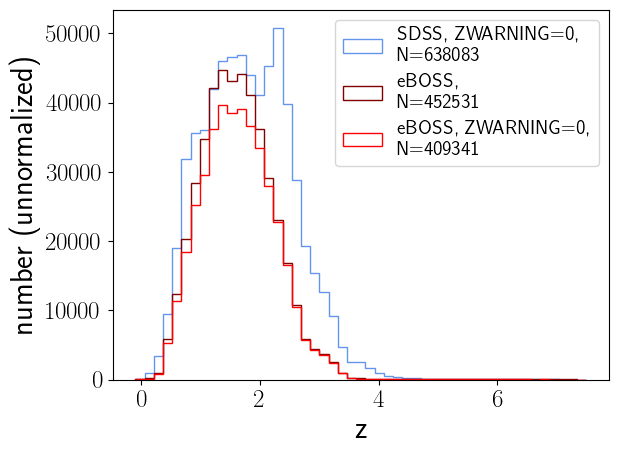

In [116]:
bins = np.linspace(-0.1, 7.5, 50)
_ = plt.hist(tab_sqall['z_sdss'], bins=bins, histtype='step', color='cornflowerblue', 
             label=f'SDSS, ZWARNING=0,\nN={N_sdss}')
_ = plt.hist(tab_eboss['Z'][i_rezaie], bins=bins, histtype='step', color='maroon', 
             label=f'eBOSS, \nN={N_eboss}')
_ = plt.hist(tab_eboss['Z'][i_rezaie & i_zwarning0], bins=bins, histtype='step', color='red', 
             label=f'eBOSS, ZWARNING=0, \nN={N_eboss_zwarning0}')
plt.legend(fontsize=14)
plt.xlabel('z')
plt.ylabel('number (unnormalized)')

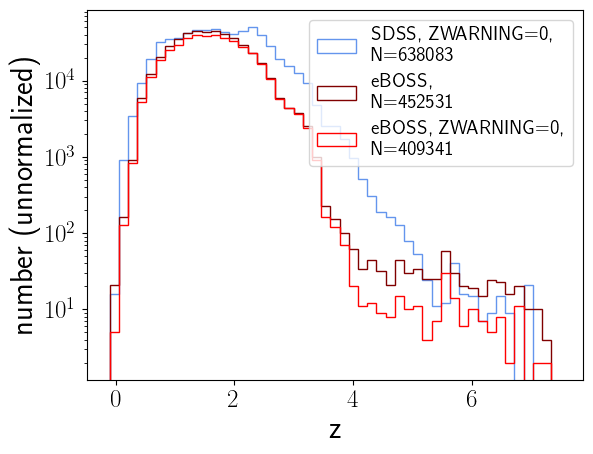

In [117]:
bins = np.linspace(-0.1, 7.5, 50)
_ = plt.hist(tab_sqall['z_sdss'], bins=bins, histtype='step', color='cornflowerblue', 
             label=f'SDSS, ZWARNING=0,\nN={N_sdss}')
_ = plt.hist(tab_eboss['Z'][i_rezaie], bins=bins, histtype='step', color='maroon', 
             label=f'eBOSS, \nN={N_eboss}')
_ = plt.hist(tab_eboss['Z'][i_rezaie & i_zwarning0], bins=bins, histtype='step', color='red', 
             label=f'eBOSS, ZWARNING=0, \nN={N_eboss_zwarning0}')
plt.legend(fontsize=14)
plt.xlabel('z')
plt.ylabel('number (unnormalized)')
plt.yscale('log')

In [119]:
tab_sqall.columns

<TableColumns names=('ra','dec','source_id','ra_sdss','dec_sdss','objid','z_sdss','thing_id','u_mag_sdss','g_mag_sdss','r_mag_sdss','i_mag_sdss','z_mag_sdss','u_mag_err_sdss','g_mag_err_sdss','r_mag_err_sdss','i_mag_err_sdss','z_mag_err_sdss','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','phot_bp_n_obs','phot_rp_n_obs','dec_unwise','mag_w1_vg','mag_w2_vg','ra_unwise','unwise_objid','dist_arcsec')>

In [120]:
tab_eboss.columns

<TableColumns names=('RUN','CAMCOL','FIELD','ID','RERUN','FIBER2MAG','RA','DEC','PSFFLUX','PSFFLUX_IVAR','EXTINCTION','FIBER2FLUX','FIBER2FLUX_IVAR','MODELFLUX','MODELFLUX_IVAR','MODELMAG','W1_MAG','W1_MAG_ERR','W1_NANOMAGGIES','W1_NANOMAGGIES_IVAR','W2_NANOMAGGIES','W2_NANOMAGGIES_IVAR','OBJID_TARGETING','CHUNK','TILE','LOCATIONID','NTILES','BOSSTILE_STATUS','TRIMMED','IDUPLICATE','IGEOMETRY','INGROUP','FIRSTGROUP','MULTGROUP','NEXTGROUP','SECTOR','QSO_ID','IMATCH','Z','PLATE','FIBERID','MJD','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','IS_QSO_FINAL','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','DELTACHI2_MGII','AUTOCLASS_PQN','RANDOM_SELECT','Z_10K','IS_QSO_10K','PRIM_REC','Z_VI','ZWARNING','Z_PCA','XFOCAL','YFOCAL','PLATESN2','SN_MEDIAN_ALL','SPEC1_G','SPEC1_R','SPEC1_I','SPE

In [122]:
i_eboss_in_squall = np.in1d(tab_eboss['OBJID_TARGETING'], tab_sqall['objid'])
print(np.sum(i_eboss_in_squall), len(i_eboss_in_squall))

332376 655521


In [129]:
i_eboss_in_squall = np.isin(tab_eboss['OBJID_TARGETING'][i_rezaie & i_zwarning0], tab_sqall['objid'])
print(np.sum(i_eboss_in_squall), len(i_eboss_in_squall))

308938 409341


In [124]:
tab_sdss.columns

<TableColumns names=('SDSS_NAME','RA','DEC','PLATE','MJD','FIBERID','AUTOCLASS_PQN','AUTOCLASS_DR14Q','IS_QSO_QN','Z_QN','RANDOM_SELECT','Z_10K','Z_CONF_10K','PIPE_CORR_10K','IS_QSO_10K','THING_ID','Z_VI','Z_CONF','CLASS_PERSON','Z_DR12Q','IS_QSO_DR12Q','Z_DR7Q_SCH','IS_QSO_DR7Q','Z_DR6Q_HW','Z_DR7Q_HW','IS_QSO_FINAL','Z','SOURCE_Z','Z_PIPE','ZWARNING','OBJID','Z_PCA','ZWARN_PCA','DELTACHI2_PCA','Z_HALPHA','ZWARN_HALPHA','DELTACHI2_HALPHA','Z_HBETA','ZWARN_HBETA','DELTACHI2_HBETA','Z_MGII','ZWARN_MGII','DELTACHI2_MGII','Z_CIII','ZWARN_CIII','DELTACHI2_CIII','Z_CIV','ZWARN_CIV','DELTACHI2_CIV','Z_LYA','ZWARN_LYA','DELTACHI2_LYA','Z_LYAWG','Z_DLA','NHI_DLA','CONF_DLA','BAL_PROB','BI_CIV','ERR_BI_CIV','AI_CIV','ERR_AI_CIV','BI_SIIV','ERR_BI_SIIV','AI_SIIV','ERR_AI_SIIV','BOSS_TARGET1','EBOSS_TARGET0','EBOSS_TARGET1','EBOSS_TARGET2','ANCILLARY_TARGET1','ANCILLARY_TARGET2','NSPEC_SDSS','NSPEC_BOSS','NSPEC','PLATE_DUPLICATE','MJD_DUPLICATE','FIBERID_DUPLICATE','SPECTRO_DUPLICATE','SKYVERSION

In [131]:
len(tab_sdss)

750414

In [130]:
i_eboss_in_squall = np.isin(tab_eboss['OBJID_TARGETING'][i_rezaie], tab_sdss['OBJID'])
print(np.sum(i_eboss_in_squall), len(i_eboss_in_squall))

345835 452531


In [128]:
i_eboss_in_squall = np.isin(tab_eboss['OBJID_TARGETING'][i_rezaie & i_zwarning0], tab_sdss['OBJID'])
print(np.sum(i_eboss_in_squall), len(i_eboss_in_squall))

308951 409341


In [127]:
i_eboss_in_squall = np.isin(tab_eboss['OBJID_TARGETING'], tab_sdss['OBJID'])
print(np.sum(i_eboss_in_squall), len(i_eboss_in_squall))

375728 655521


# Write quantities to file

In [246]:
with open(fn_quants, 'w') as f:
    for key, val in quants.items():
        print(key, val)
        if save:
            f.write(f'{key} = {val}\n')
if save:
    print()
    print(f"Saved to {fn_quants}!")

p_reliable_wiseps 59
Avhi 0.5
N_gcathi 1,209,839
area_gcathi 29153.70 deg$^2$
fsky_gcathi 0.71
nbar_gcathi 41.50 deg$^-2$
volume_effective_gcathi 7.01 $(h^{-1}\,Gpc)^3$
volume_spanning_gcathi 138.46 $(h^{-1}\,Gpc)^3$
N_gcatlo 705,365
area_gcatlo 29153.70 deg$^2$
fsky_gcatlo 0.71
nbar_gcatlo 24.19 deg$^-2$
volume_effective_gcatlo 2.90 $(h^{-1}\,Gpc)^3$
volume_spanning_gcatlo 138.46 $(h^{-1}\,Gpc)^3$
N_gpurer 1,261,890
area_gpurer 29149.51 deg$^2$
fsky_gpurer 0.71
nbar_gpurer 43.29 deg$^-2$
volume_effective_gpurer 6.43 $(h^{-1}\,Gpc)^3$
volume_spanning_gpurer 138.44 $(h^{-1}\,Gpc)^3$
N_wiseps 1,106,010
area_wiseps 22203.51 deg$^2$
fsky_wiseps 0.54
nbar_wiseps 49.81 deg$^-2$
volume_effective_wiseps 7.21 $(h^{-1}\,Gpc)^3$
volume_spanning_wiseps 105.45 $(h^{-1}\,Gpc)^3$
N_eboss 190,194
area_eboss 5589.70 deg$^2$
fsky_eboss 0.14
nbar_eboss 34.03 deg$^-2$
volume_effective_eboss 1.01 $(h^{-1}\,Gpc)^3$
volume_spanning_eboss 26.55 $(h^{-1}\,Gpc)^3$
zmed_gcathi 1.47
frac_acc_dzlo_gcathi 0.61
frac